In [12]:
# Note that the struct's contents are different from the previous ones
struct Models
    # parameters
    β::Float64 # discount factor
    γ::Float64 # relative risk aversion
    
    # factor price
    rent::Float64 # net interest rate

    # labor income
    y1::Float64
    y2::Float64
    y3::Float64

    # risk
    tran::Matrix{Float64}
    endow::Vector{Float64}
            
    # grid
    na::Int64 # the number of saving grid
    ny::Int64 # the number of income grid   
    a_max::Float64 # the maximum value of saving grid
    a_min::Float64 # the minimum value of saving grid
    grid_a::Vector{Float64} # saving grid
end

In [13]:
function Calibration()
    # set parameters here
    β = 0.985^20
    γ = 2.0
    rent = 1.025^20 - 1.0
    y1 = 1.0
    y2 = 1.2
    y3 = 0.4

    tran = [0.7451 0.2528 0.0021; 0.1360 0.7281 0.1360; 0.0021 0.2528 0.7451]
    endow = [0.8027, 1, 1.2457]
    ny = 3

    na = 21
    a_max = 2.0
    a_min = 0.0

    grid_a = collect(LinRange(a_min, a_max, na))

    return Models(β, γ, rent, y1, y2, y3, tran, endow, na, ny, a_max, a_min, grid_a)
end

Calibration (generic function with 1 method)

In [14]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

In [9]:
# Load the required packages
using Plots
# pyplot()
using Roots
using Interpolations
using LinearAlgebra # dot product is needed to calculate expected values

## Introducing risk
<!-- ## リスクの導入 -->

- In real business cycle models and New Keynesian DSGE models, exogenous shocks, such as total factor productivity (TFP) shocks and monetary policy shocks, are considered to be the driving force of business cycles
<!-- - RBCモデルやニューケインジアンDSGEモデルでは、全要素生産性(total factor productivity, TFP)ショックや金融政策ショックといった外生的なショックが景気循環のドライビングファクターであると考える。あるいは、各家計も所得変動や健康状態等のリスクに直面している。 -->

- Therefore, some economic variables can be stochastic. In this case, an economic agent makes decisions so as to maximize the expected value of the lifetime utility
<!-- - そのため、経済変数のいくつかは確率変数になるかもしれない。その場合、経済主体は生涯効用の期待値を最大化するように意思決定を行っていると考える。 -->

- Consider the three-period model again. An economic agent faces uncertainty, and its labor endowments are stochastic. That is, $(y_{1},y_{2})$ can change over time. Also, $y_{2}$ is stochastically determined depending on $y_{1}$
<!-- - 再び3期間モデルを考えよう。経済主体は不確実性に直面していて、生まれたときの労働賦与量(labor endowment)が異なるとする。すなわち、$(y_{1},y_{2})$が変化し得る。また、$y_{2}$は$y_{1}$に依存する形で確率的に決定するものとする。 -->

- Specifically, each of $(y_{1},y_{2})$ takes either of the following discretized values
<!-- % - 具体的には、$(y_{1},y_{2})$はそれぞれ、以下の離散的な値のいずれかを取るものとする。 -->

$$
  y_{1,j} \in \{y_{1,1},y_{1,2},\cdots,y_{1,n}\} \\
  y_{2,j} \in \{y_{2,1},y_{2,2},\cdots,y_{2,n}\}  
$$

- Also, when $y_{1}=y_{i}$ is given, the probability of $y_{2}=y_{j}$ is given by the following transition matrix
<!-- - また、$y_{1}=y_{i}$が与えられたとき、$y_{2}=y_{j}$となる確率は、以下の遷移行列(transition matrix)で与えられる: -->

$$
  \Pi = \left[
\begin{matrix} 
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1,n} \\
\vdots & \vdots & \cdots & \vdots \\
\pi_{n,1} & \pi_{n,2} & \cdots & \pi_{n,n}
\end{matrix}
\right]
$$

where $\pi_{i,j}$ is the conditional probability of $y_{2}=y_{j}$ taking $y_{1}=y_{i}$ as given
<!-- ここで、$\pi_{i,j}$は、$y_{1}=y_{i}$が与えられたとき、$y_{2}=y_{j}$となる条件付き確率である。 -->

- What has changed when solving the model by introducing uncertainty into labor endowments?
<!-- - 労働所得に不確実性を導入したことによって、モデルを解く際に何が変わったのであろうか。 -->

- First, the number of state variables increases by one. That is, the production function is a function of two variables. This is because when the economic agent makes decisions in the young period, its budget changes depending not only the current assets $a$ but also labor income $y$, which affects its decision-making
<!-- - 第1に状態変数の数が1つ増えるという違いがある。すなわち、生産関数は$a'=g(a,y)$のように2変数の関数となる。これは若年期の意思決定を行う際に、現在の資産$a$だけでなく、労働所得$y$に依存して予算が変わり、意思決定も影響を受けるためである。 -->


- The first-order condition from the middle-age to old period is the same as before
<!-- - 中年期から老年期にかけての一階条件は、これまでと同じく、 -->

$$
  u'(y_{2,j}+(1+r)a_{2,i}-a_{3}) = \beta (1+r) u'(y_{3}+(1+r)a_{3}) \tag{1}
$$

Note that there is no risk in pesion $y_{3}$ recieved in the old period. By solving this equation, we obtain $a_{3}=g(a_{2,i},y_{2,j})$
<!-- となる。老年期の年金$y_{3}$にはリスクがない点に注意。この式を解くことで、$a_{3}=g(a_{2,i},y_{2,j})$を得る。 -->

- Second, we need to calculate the expected utility as the next period's labor income is uncertain in the young period. Therefore, the first-order condition from the young to middle-age period is
<!-- - 第2の変更点として、若年期において次期の労働所得が不確実であることから、期待効用(expected utility)を計算する必要が出てくる。このため若年期から中年期にかけての一階条件は、 -->

$$
  u'(y_{1,j}+a_{1,i}-a_{2}) = \beta (1+r) \mathbb{E} u'(y_{2}+(1+r)a_{2}-a_{3}) \\
  = \beta (1+r) \mathbb{E} u'(y_{2}+(1+r)a_{2}-g(a_{2},y_{2}))
$$

<!-- となる。 -->

- By using the conditional probability, the expected value in the right-hand side can be written as
<!-- - 条件付き確率を用いると、右辺の期待値は以下のように書くことができる。 -->

$$
  u'(y_{1,j}+a_{1,i}-a_{2}) = \\
  \beta (1+r) \sum_{k=1}^{n} \pi_{j,k} u'(y_{2,k}+(1+r)a_{2}-g(a_{2},y_{2,k})) \tag{2}
$$


- Algorithm
<!-- - アルゴリズム -->

1. Reset parameters adjusting to the three-period model. Calibrate the parameters regarding the income risk

2. Let $a_{2,i} \in \{a_{2,1},\dots,a_{2,I}\}$ be discretized assets in the second period

3. Find $a_{3}$ by solving Eq. (1) for each $(a_{2,i},y_{2,j})$. Now we have one more state variable due to income risk (One more layer of the loop)

4. Let $a_{1,i} \in \{a_{1,1},\dots,a_{1,I}\}$ be discretized assets in the first period

5. Fix an interpolation method to approximate $a_{3}=\tilde{g}(a_{2},y_{2})$

6. Taking the saving function in the middle-age period obtained in the step 3, find $a_{2}$ by solving Eq. (2) for each $(a_{1,i},y_{1,j})$. 

<!-- 1. 3期間モデルにあわせてパラメータを再設定する。所得リスクのパラメータをカリブレートする。

2. $a_{2,i} \in \{a_{2,1},\dots,a_{2,I}\}$を離散化した第2期の資産とする。

3. 各$(a_{2,i},y_{2,j})$について、(1)式を解くような$a_{3}$を探し出す。所得リスクの存在によって状態変数が一つ増えた（＝ループが多重になった）点に注意してほしい。

4. $a_{2,i} \in \{a_{2,1},\dots,a_{2,I}\}$を離散化した第1期の資産とする。

5. $a_{3}=\tilde{g}(a_{2},y_{2})$を近似する内挿法を一つ定める。

6. ステップ3で得た中年期の貯蓄関数$a_{3}=\tilde{g}(a_{2})$を所与として、各$(a_{1,i},y_{1,j})$について、(2)式を解くような$a_{2}$を探し出す。 -->

In [5]:
function resid_three_period2(a3::Float64, a2::Float64, e2::Int64, params::Models)

    # The left-hand side of the Euler equation: The marginal utility when middle-aged
    # Define cash on hand based on the right-hand side of the budget constraint
    coh = (1 + params.rent)*a2 + params.y2*params.endow[e2]
    if coh - a3 > 0.0 # consumption is positive
        mu2 = mu_CRRA(coh - a3, params.γ)
    else
        mu2 = 10000.0
    end

    # The marginal utility when old
    mu3 = mu_CRRA((1 + params.rent)*a3 + params.y3, params.γ)

    # Residual
    return params.β*(1 + params.rent)*(mu3/mu2) - 1.0

end

resid_three_period2 (generic function with 1 method)

In [15]:
# Set parameters
params = Calibration()

# Prepare empty variables
a2_nl = zeros(params.na, params.ny);

# Find a such that the residual function becomes zero for each w_{i}
for i = 1:length(params.endow), j = 1:params.na

    a2_val = params.grid_a[j]

    # Make a function which has a as the only argument
    resid_three_period2!(a3) = resid_three_period2(a3, a2_val, i, params)

    # 0.01 is an initial value to find the zero
    a2_nl[j, i] = find_zero(resid_three_period2!, 0.01)

end

print(a2_nl)

[0.2409775582353271 0.3361025016522554 0.45456270741778654; 0.3068135508711914 0.4019384942881199 0.5203987000536509; 0.3726495435070557 0.46777448692398405 0.5862346926895152; 0.4384855361429199 0.5336104795598482 0.6520706853253794; 0.5043215287787843 0.5994464721957125 0.7179066779612437; 0.5701575214146486 0.6652824648315768 0.783742670597108; 0.6359935140505127 0.7311184574674412 0.8495786632329722; 0.7018295066863771 0.7969544501033055 0.9154146558688366; 0.7676654993222416 0.8627904427391696 0.981250648504701; 0.8335014919581055 0.928626435375034 1.047086641140565; 0.89933748459397 0.9944624280108985 1.1129226337764293; 0.9651734772298345 1.0602984206467625 1.1787586264122938; 1.0310094698656984 1.126134413282627 1.244594619048158; 1.096845462501563 1.1919704059184912 1.3104306116840223; 1.1626814551374272 1.2578063985543553 1.3762666043198866; 1.2285174477732914 1.3236423911902198 1.4421025969557508; 1.2943534404091557 1.389478383826084 1.5079385895916155; 1.36018943304502 1.45

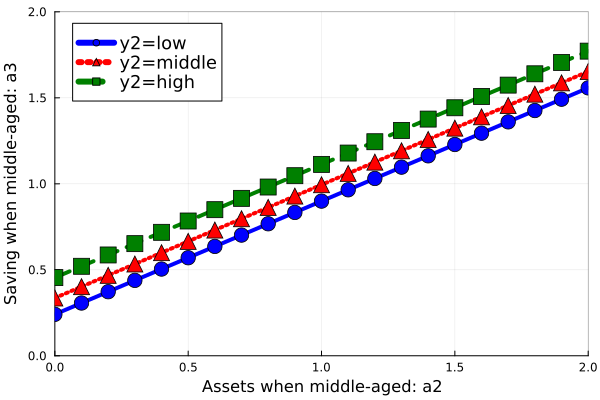

In [21]:
plt = plot(params.grid_a, a2_nl[:, 1],
    color = :blue,
    marker = :circle,
    legend = :topleft,
    xlims = (0, 2.0),
    ylims = (0, 2.0),
    label = ("y2=low"),
    xlabel = ("Assets when middle-aged: a2"),
    ylabel = ("Saving when middle-aged: a3"),
    linewidth = 4,
    markersize = 8,
#     titlefont = font("HackGen35Nerd", 12),
#     guidefont = font("HackGen35Nerd", 12),
#     tickfont = font("HackGen35Nerd", 8),
#     legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_a, a2_nl[:, 2], markershape=:utriangle, markersize = 8, linestyle = :dot, linewidth = 4, color = :red, label="y2=middle")
plot!(params.grid_a, a2_nl[:, 3], markershape=:rect, markersize = 8, linestyle = :dash, linewidth = 4, color = :green, label="y2=high")
#savefig("../figure/Fig2_pol_three_period23_risk.eps")

In [18]:
function resid_three_period1(a2::Float64, a1::Float64, e1::Int64, a2_nl::Matrix{Float64}, params::Models)

    # The left-hand side of the Euler equation: The marginal utility when young
    # Define cash on hand based on the right-hand side of the budget constraint    
    coh = a1 + params.y1*params.endow[e1]
    if coh - a2 > 0.0 # Consumption is positive
        mu1 = mu_CRRA(coh - a2, params.γ)
    else
        mu1 = 10000.0
    end

    mu2 = zeros(params.ny)
    for i = 1:params.ny
        # Consumption when middle-aged by linear interpolation: It is better to place it outside the function 
        # as it is a waste of time to calculate coefficients every time when the function is called!
        interp1 = LinearInterpolation(params.grid_a, a2_nl[:, i], extrapolation_bc=Line())
        a3_approx = interp1(a2)
        cons = (1 + params.rent)*a2 + params.y2*params.endow[i] - a3_approx

        # The marginal utility when middle-aged
        mu2[i] = mu_CRRA(cons, params.γ)
    end

    # Residual
    exp_val = dot(params.tran[e1, :], mu2)
    return params.β*(1 + params.rent)*(exp_val/mu1) - 1.0

end

resid_three_period1 (generic function with 1 method)

In [22]:
# Prepare empty variables
a1_nl = zeros(params.na, params.ny);

# Find a such that the residual function becomes zero for each (w_{i},y_{j})
for i = 1:length(params.endow), j = 1:params.na

    a1_val = params.grid_a[j]

    # Make a function which has a as the only argument
    resid_three_period1!(a2) = resid_three_period1(a2, a1_val, i, a2_nl, params)

    # 0.01 is an initial value to find the zero
    a1_nl[j, i] = find_zero(resid_three_period1!, 0.01)

end

print(a1_nl)

[0.06299252039694012 0.11644201278488359 0.18476162289766104; 0.11571952346174602 0.16908502732452202 0.2374610216260146; 0.16846282946370633 0.22175210365888584 0.29017726364615026; 0.221220119881136 0.27443985450728264 0.342908219542588; 0.27398949409699636 0.32714550742961473 0.3956521032058708; 0.3267693796904921 0.37986677007777586 0.4484074055098266; 0.37955846479127514 0.4326017296481436 0.5011728427590361; 0.43235564644092417 0.4853487767657939 0.5539473162128555; 0.4851599907263629 0.5381065471070813 0.6067298800102026; 0.5379707016792806 0.5908738760921902 0.6595197155324115; 0.5907870967790627 0.6436497633382169 0.7123161107478762; 0.6436085874838386 0.6964333444915715 0.7651184434463569; 0.6964346636284572 0.7492238687028386 0.8179261675357682; 0.7492648808241179 0.802020680461204 0.8707388017690952; 0.8020988502082977 0.8548232048298279 0.9235559204138507; 0.8549362300499505 0.9076309353581137 0.9763771454850113; 0.907776718830399 0.9604434241185243 1.02920214024452; 0.960

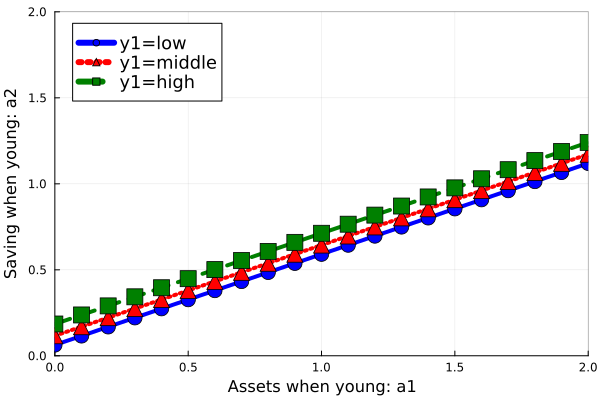

In [23]:
plt = plot(params.grid_a, a1_nl[:, 1],
    color = :blue,
    marker = :circle,
    legend = :topleft,
    xlims = (0, 2.0),
    ylims = (0, 2.0),
    label = ("y1=low"),
    xlabel = ("Assets when young: a1"),
    ylabel = ("Saving when young: a2"),    
    linewidth = 4,
    markersize = 8,
#     titlefont = font("HackGen35Nerd", 12),
#     guidefont = font("HackGen35Nerd", 12),
#     tickfont = font("HackGen35Nerd", 8),
#     legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_a, a1_nl[:, 2], markershape=:utriangle, markersize = 8, linestyle = :dot, linewidth = 4, color = :red, label="y1=middle")
plot!(params.grid_a, a1_nl[:, 3], markershape=:rect, markersize = 8, linestyle = :dash, linewidth = 4, color = :green, label="y1=high")
#savefig("../figure/Fig2_pol_three_period12_risk.eps")